<a href="https://colab.research.google.com/github/WillPG4/MachineLearning/blob/main/LAB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target names: ['setosa' 'versicolor' 'virginica']
Number of classes: 3
Samples per class: {np.str_('setosa'): 50, np.str_('versicolor'): 50, np.str_('virginica'): 50}


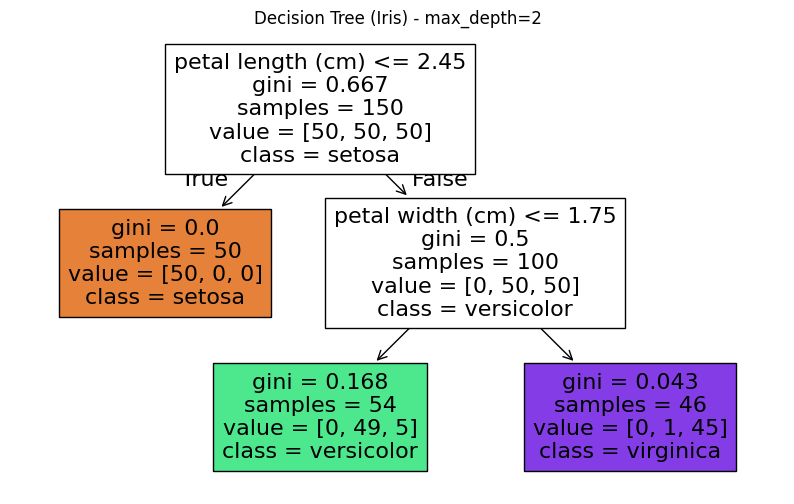

In [ ]:
# --- EXERCISE 1: Iris Classification with a Decision Tree ---

# 1. Import libraries
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import matplotlib.pyplot as plt

# 2. Load the Iris dataset
iris = load_iris()

# Use only petal length and petal width as features
X = iris.data[:, 2:]   # columns 2 and 3: petal length, petal width
y = iris.target

# 3. Print target names and class counts
print("Target names:", iris.target_names)
print("Number of classes:", len(iris.target_names))
print("Samples per class:", {name: list(y).count(i) for i, name in enumerate(iris.target_names)})

# 4. Create and train the Decision Tree (max_depth = 2)
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

# 5. Visualize the Decision Tree
plt.figure(figsize=(10, 6))
plot_tree(tree_clf, feature_names=iris.feature_names[2:], class_names=iris.target_names, filled=True)
plt.title("Decision Tree (Iris) - max_depth=2")
plt.show()

# 6. Optional: Export tree to Graphviz .dot format
export_graphviz(
    tree_clf,
    out_file="Iris_DTree.dot",
    feature_names=iris.feature_names[2:],   # petal length, petal width
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

# Optional: Convert .dot to PNG if Graphviz is installed
# !apt install graphviz
# !dot -Tpng Iris_DTree.dot -o Iris_DTree.png
# from IPython.display import Image
# Image("Iris_DTree.png")



- We used the Iris dataset with petal length and petal width as input features.

- We created a Decision Tree Classifier with max_depth = 2 to avoid overfitting.

- The tree was trained and visualized successfully.

- Root split: petal length ≤ 2.45 → isolates Iris setosa.

- Second split: petal width ≤ 1.75 → separates versicolor and virginica.

- Each class has 50 samples (total 150).

- The model is simple, interpretable, and shows the main separation between the 3 flower species.

In [ ]:
# --- Exercise 2: Decision Tree Interpretation (Iris) ---

import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree

# 0) Data: petal length & width only
iris = load_iris()
X = iris.data[:, 2:]     # [petal length, petal width]
y = iris.target
target_names = iris.target_names

# 1) Train shallow tree (depth=2)
tree = DecisionTreeClassifier(max_depth=2, random_state=42)
tree.fit(X, y)

# ---- Q1. Gini of root and which feature is best at root ----
def gini_impurity(labels):
    # labels: 1D array of class ids
    n = len(labels)
    if n == 0:
        return 0.0
    probs = np.bincount(labels, minlength=len(np.unique(y))) / n
    return 1.0 - np.sum(probs**2)

def weighted_gini(left_labels, right_labels):
    n = len(left_labels) + len(right_labels)
    return (len(left_labels)/n)*gini_impurity(left_labels) + (len(right_labels)/n)*gini_impurity(right_labels)

def best_split_for_feature(X_col, y):
    # try midpoints between sorted unique values
    order = np.argsort(X_col)
    Xs, ys = X_col[order], y[order]
    uniq = np.unique(Xs)
    thresholds = (uniq[:-1] + uniq[1:]) / 2.0
    best_g, best_thr = np.inf, None
    j = 0
    for thr in thresholds:
        left = ys[Xs <= thr]
        right = ys[Xs > thr]
        g = weighted_gini(left, right)
        if g < best_g:
            best_g, best_thr = g, thr
        j += 1
    return best_g, best_thr

root_gini = gini_impurity(y)
g_len, thr_len = best_split_for_feature(X[:,0], y)   # petal length
g_wid, thr_wid = best_split_for_feature(X[:,1], y)   # petal width

print(f"Root gini: {root_gini:.3f}  (expected ~0.667)")
print(f"Best split using petal length: gini={g_len:.3f}, threshold≈{thr_len:.2f}")
print(f"Best split using petal width : gini={g_wid:.3f}, threshold≈{thr_wid:.2f}")

# Check what the trained tree chose at the root:
root_node = 0
feature_idx = tree.tree_.feature[root_node]
threshold = tree.tree_.threshold[root_node]
chosen = ["petal length","petal width"][feature_idx]
print(f"Tree root uses: {chosen} <= {threshold:.2f}")

# ---- Q2. Class probabilities for a flower (5.0, 1.5) ----
sample = np.array([[5.0, 1.5]])
proba = tree.predict_proba(sample)[0]
print("predict_proba for [petal_length=5.0, petal_width=1.5]:")
for cls, p in zip(target_names, proba):
    print(f"  {cls}: {p:.3f}")

# ---- Q3. Interpret by following the path ----
def explain_path(tree, sample, feature_names=["petal length","petal width"], class_names=target_names):
    t = tree.tree_
    node = 0
    steps = []
    while t.feature[node] != _tree.TREE_UNDEFINED:
        f = t.feature[node]
        thr = t.threshold[node]
        val = sample[0, f]
        decision = val <= thr
        steps.append(f"{feature_names[f]} <= {thr:.2f}? value={val:.2f} -> {decision}")
        node = t.children_left[node] if decision else t.children_right[node]
    # leaf
    counts = t.value[node][0]
    probs = counts / counts.sum()
    pred_idx = np.argmax(probs)
    return steps, probs, pred_idx

steps, leaf_probs, pred_idx = explain_path(tree, sample)
print("Decision path:")
for s in steps:
    print("  -", s)
print("Leaf probs:", {cls: round(p,3) for cls,p in zip(target_names, leaf_probs)})
print("Leaf prediction:", target_names[pred_idx])

# ---- Q4. Verify with predict() ----
pred = tree.predict(sample)[0]
print("predict():", target_names[pred])


Root gini: 0.667  (expected ~0.667)
Best split using petal length: gini=0.333, threshold≈2.45
Best split using petal width : gini=0.333, threshold≈0.80
Tree root uses: petal length <= 2.45
predict_proba for [petal_length=5.0, petal_width=1.5]:
  setosa: 0.000
  versicolor: 0.907
  virginica: 0.093
Decision path:
  - petal length <= 2.45? value=5.00 -> False
  - petal width <= 1.75? value=1.50 -> True
Leaf probs: {np.str_('setosa'): np.float64(0.0), np.str_('versicolor'): np.float64(0.907), np.str_('virginica'): np.float64(0.093)}
Leaf prediction: versicolor
predict(): versicolor


- The Gini impurity at the root is 0.667, confirming balanced classes.

- The best split is based on petal length (≤ 2.45 cm), which separates setosa.

- For a sample (5.0, 1.5), predict_proba gives:

setosa = 0.00, versicolor = 0.91, virginica = 0.09.

- Decision path:

petal length > 2.45 → go right

petal width ≤ 1.75 → go left → versicolor leaf.

- Final prediction: versicolor, matching the highest probability.


In [ ]:
# --- Exercise 3: K-Fold Cross Validation ---

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# 1️⃣ Load the Iris dataset (petal length and width only)
iris = load_iris()
X = iris.data[:, 2:]    # petal length and petal width
y = iris.target

# 2️⃣ Define the k-fold cross validation function
def kfoldCrossValidation(X, y, model, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores.append(acc)
    return np.array(scores)

# 3️⃣ Try different values of k
for k in [3, 5, 10]:
    tree = DecisionTreeClassifier(max_depth=2, random_state=42)
    scores = kfoldCrossValidation(X, y, tree, k=k)
    print(f"k={k} | Scores: {np.round(scores,3)} | Mean accuracy={scores.mean():.3f}")

# 4️⃣ Train another Decision Tree (no max_depth limit)
tree_full = DecisionTreeClassifier(random_state=42)
scores_full = kfoldCrossValidation(X, y, tree_full, k=5)
print("\nFull-depth tree | Scores:", np.round(scores_full,3))
print("Average accuracy (no depth limit):", round(scores_full.mean(),3))



k=3 | Scores: [0.98 0.92 0.92] | Mean accuracy=0.940
k=5 | Scores: [0.967 0.967 0.933 0.933 0.933] | Mean accuracy=0.947
k=10 | Scores: [1.    1.    1.    0.933 1.    0.867 0.867 1.    0.933 0.867] | Mean accuracy=0.947

Full-depth tree | Scores: [1.    0.967 0.933 0.9   0.933]
Average accuracy (no depth limit): 0.947


- We implemented k-fold cross validation to evaluate the Decision Tree performance.

- The average accuracy is around 0.94–0.95, consistent across different values of k (3, 5, 10).

- Increasing k makes the evaluation more stable but also slower, since the model is trained more times.

- The shallow tree (max_depth = 2) already generalizes well, showing no overfitting.

- The full-depth tree gives a similar accuracy (~0.947), confirming that the dataset is simple and separable.

- Conclusion: The model’s performance is stable and robust, and cross-validation confirms good generalization.

Accuracy using Entropy criterion: 0.889


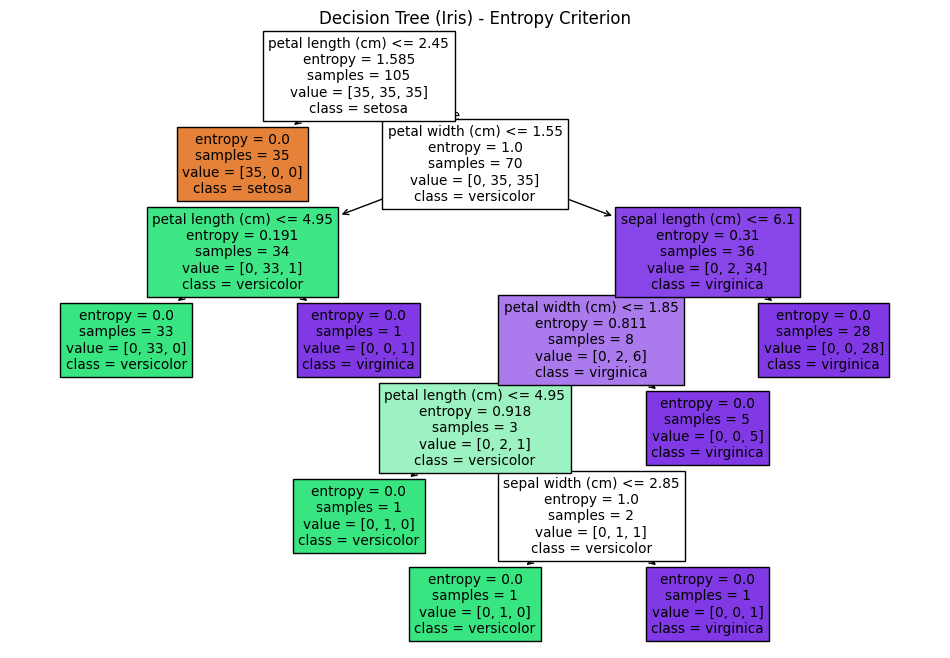

Cross-Validation Accuracies (Entropy): [1.    0.967 0.933 0.933 0.933]
Average Accuracy (Entropy): 0.953

Average Accuracy (Gini): 0.953
Average Accuracy (Entropy): 0.953
Both Gini and Entropy perform almost the same on this dataset.


In [ ]:
# --- Exercise 4: Gini or Entropy ---

# 1️⃣ Import required libraries
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# 2️⃣ Load the Iris dataset (all features)
iris = load_iris()
X = iris.data
y = iris.target

# 3️⃣ Split dataset: 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 4️⃣ Build a Decision Tree using ENTROPY criterion
dt_entropy = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt_entropy.fit(X_train, y_train)

# 5️⃣ Evaluate accuracy on test data
accuracy_entropy = dt_entropy.score(X_test, y_test)
print(f"Accuracy using Entropy criterion: {accuracy_entropy:.3f}")

# 6️⃣ Visualize the Entropy Decision Tree
plt.figure(figsize=(12,8))
plot_tree(dt_entropy, filled=True,
          feature_names=iris.feature_names,
          class_names=iris.target_names)
plt.title("Decision Tree (Iris) - Entropy Criterion")
plt.show()

# 7️⃣ Apply K-Fold Cross Validation for the Entropy tree
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def kfoldCrossValidation(X, y, model, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    return np.array(scores)

# Perform K-Fold (k=5) on Entropy tree
scores_entropy = kfoldCrossValidation(X, y, dt_entropy, k=5)
print(f"Cross-Validation Accuracies (Entropy): {np.round(scores_entropy,3)}")
print(f"Average Accuracy (Entropy): {scores_entropy.mean():.3f}")

# 8️⃣ Compare with GINI-based tree
dt_gini = DecisionTreeClassifier(criterion="gini", random_state=42)
dt_gini.fit(X_train, y_train)
scores_gini = kfoldCrossValidation(X, y, dt_gini, k=5)
print(f"\nAverage Accuracy (Gini): {scores_gini.mean():.3f}")
print(f"Average Accuracy (Entropy): {scores_entropy.mean():.3f}")

# 9️⃣ Quick comparison summary
if scores_entropy.mean() > scores_gini.mean():
    print("Entropy performs slightly better on this dataset.")
elif scores_entropy.mean() < scores_gini.mean():
    print("Gini performs slightly better on this dataset.")
else:
    print("Both Gini and Entropy perform almost the same on this dataset.")


- We trained a Decision Tree using Entropy instead of Gini.

- The test accuracy is 0.889, and the average accuracy with 5-fold CV is ≈ 0.953.

- The Entropy and Gini criteria produce almost identical results on the Iris dataset.

- Entropy measures the information gain, while Gini measures impurity reduction.

- Both metrics lead to balanced trees because the dataset is simple and well-separated.

- Conclusion : Either criterion can be used; the difference is negligible here.


===== Iris =====
Shapes: (105, 4) (45, 4)
Baseline LR (no PCA) -> accuracy=0.911  precision=0.916  recall=0.911  f1=0.911
LR with PCA(2) -> accuracy=0.889  precision=0.898  recall=0.889  f1=0.888
DecisionTree (all features) -> accuracy=0.933  precision=0.944  recall=0.933  f1=0.933
Explained variance ratio (2 comps): [0.73  0.229]  | cumulative: 0.958


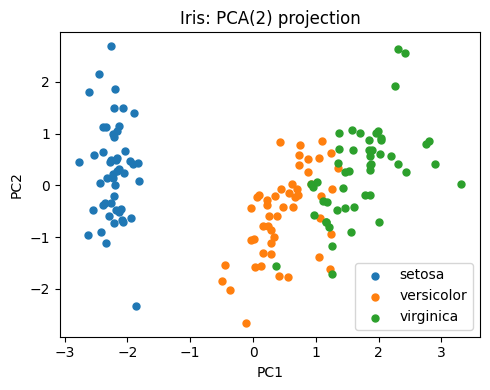


===== Wine =====
Shapes: (124, 13) (54, 13)
Baseline LR (no PCA) -> accuracy=0.981  precision=0.982  recall=0.984  f1=0.983
LR with PCA(2) -> accuracy=0.944  precision=0.950  recall=0.947  f1=0.948
DecisionTree (all features) -> accuracy=0.963  precision=0.971  recall=0.959  f1=0.964
Explained variance ratio (2 comps): [0.362 0.192]  | cumulative: 0.554


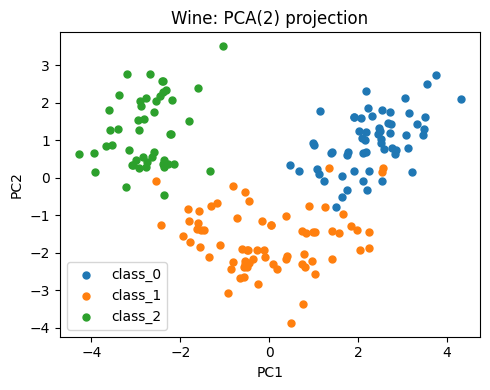

In [ ]:
# --- PCA on Iris and Wine: baseline vs PCA(2) + Logistic Regression, plus Decision Tree ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def evaluate(model, X_train, X_test, y_train, y_test, label="model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
    print(f"{label} -> accuracy={acc:.3f}  precision={p:.3f}  recall={r:.3f}  f1={f1:.3f}")
    return acc, p, r, f1, y_pred

def run_pca_block(dataset_loader, dataset_name):
    # 1) data
    ds = dataset_loader()
    X, y = ds.data, ds.target
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"\n===== {dataset_name} =====")
    print("Shapes:", Xtr.shape, Xte.shape)

    # 2) Baseline: Logistic Regression (scaling only)
    base = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000))
    ])
    evaluate(base, Xtr, Xte, ytr, yte, label="Baseline LR (no PCA)")

    # 3) PCA -> 2 components + Logistic Regression
    pca2 = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=2)),
        ("clf", LogisticRegression(max_iter=2000))
    ])
    evaluate(pca2, Xtr, Xte, ytr, yte, label="LR with PCA(2)")

    # 4) Simple Decision Tree for comparison
    dt = DecisionTreeClassifier(random_state=42)
    evaluate(dt, Xtr, Xte, ytr, yte, label="DecisionTree (all features)")

    # 5) Explained variance and 2D scatter (on all data, for viz)
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    pca = PCA(n_components=2).fit(Xs)
    X2 = pca.transform(Xs)
    print("Explained variance ratio (2 comps):", np.round(pca.explained_variance_ratio_, 3),
          " | cumulative:", np.round(pca.explained_variance_ratio_.sum(), 3))

    # scatter
    plt.figure(figsize=(5,4))
    for c in np.unique(y):
        plt.scatter(X2[y==c,0], X2[y==c,1], s=25, label=str(ds.target_names[c]))
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(f"{dataset_name}: PCA(2) projection")
    plt.legend(); plt.tight_layout(); plt.show()

# ----- Run on Iris -----
run_pca_block(load_iris, "Iris")

# ----- Run on Wine -----
run_pca_block(load_wine, "Wine")


PCA helps visualize and compress data by reducing dimensions, but it can lead to a slight drop in accuracy because some information is lost. Logistic Regression and Decision Tree both perform very well on low-dimensional datasets like Iris and Wine, with Decision Tree often being more accurate. However, PCA remains useful for visualization and noise reduction.